# Age Detection

## Setup

### Import Statements

In [77]:
import tensorflow as tf
from keras.preprocessing import image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [78]:
tf.__version__

'2.15.0'

### Notebook Presentation

In [79]:
pd.options.display.float_format = '{:,.2f}'.format

### Load the Data

In [80]:
df = pd.read_csv("./dataset/age_gender.csv")

In [81]:
df.sample(5)

,age,ethnicity,gender,img_name,pixels
10617,3,3,1,20161219230106056.jpg.chip.jpg,70 100 116 139 155 170 181 186 195 207 211 215...
19169,54,0,0,20170116193350285.jpg.chip.jpg,8 9 11 11 14 20 32 44 55 65 70 85 108 145 175 ...
21352,65,0,1,20170110133937781.jpg.chip.jpg,14 19 22 21 24 31 34 43 46 34 34 85 87 84 48 2...
4329,23,4,0,20170103234919628.jpg.chip.jpg,135 69 67 27 17 19 16 17 15 20 21 25 33 41 29 ...
21843,7,4,1,20161221193133117.jpg.chip.jpg,88 102 140 168 177 193 200 202 205 206 208 210...


## Preliminary Data Exploration

### Analyzing the Data

In [82]:
df.shape

(23705, 5)

In [83]:
df.columns

Index(['age', 'ethnicity', 'gender', 'img_name', 'pixels'], dtype='object')

In [84]:
df.isna().sum()

age          0
ethnicity    0
gender       0
img_name     0
pixels       0
dtype: int64

In [85]:
df.describe()

,age,ethnicity,gender
count,"23,705.00","23,705.00","23,705.00"
mean,33.30,1.27,0.48
std,19.89,1.35,0.50
min,1.00,0.00,0.00
25%,23.00,0.00,0.00
50%,29.00,1.00,0.00
75%,45.00,2.00,1.00
max,116.00,4.00,1.00


In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


### Visualizing the Ages

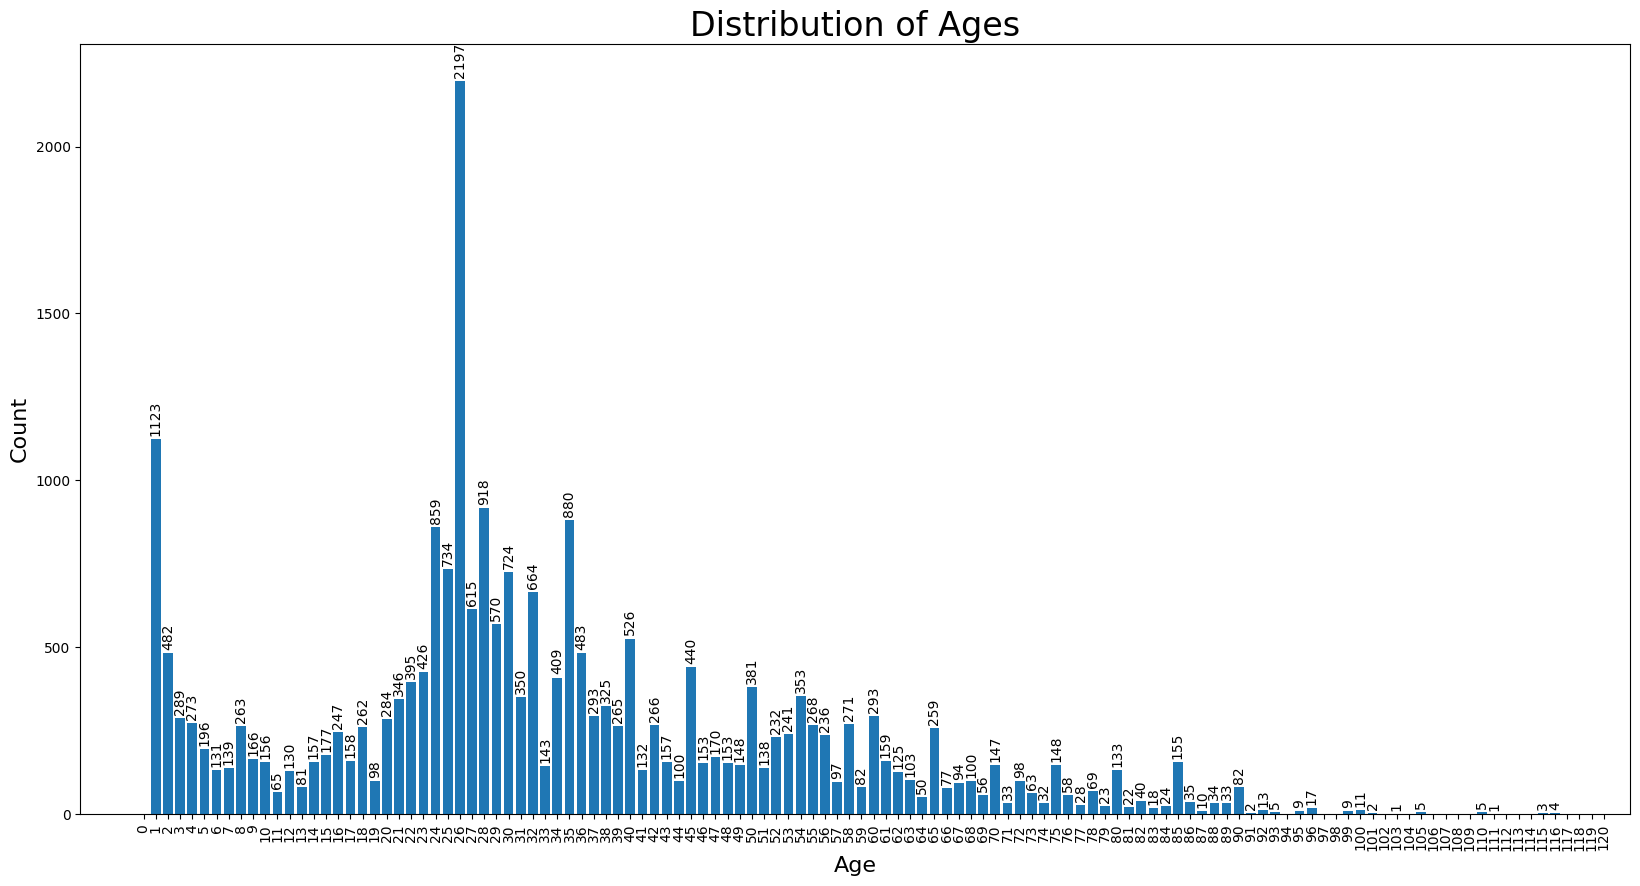

In [87]:
age_distribution = df['age'].value_counts()

plt.figure(figsize=(20, 10))
plt.bar(age_distribution.index, age_distribution.values)
plt.title("Distribution of Ages", fontsize=24)

for i, count in enumerate(age_distribution.values):
    plt.text(age_distribution.index[i], count + 10, str(count), ha='center', va='bottom', rotation=90)

plt.xticks(range(0, 121), rotation=90)
plt.xlabel('Age', fontsize=16)
plt.ylabel('Count', fontsize=16)

plt.show()

## Data Preprocessing

### Binning of the Ages

In [88]:
age_bins = [0, 3, 17, 29, 44, 65, 120]
age_labels = [0, 1, 2, 3, 4, 5]

df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)

In [89]:
age_group_map = ['0 - 3', '4 - 17', '18 - 29', '30 - 44', '45 - 64', '65+']

In [90]:
df.sample(5)

,age,ethnicity,gender,img_name,pixels,age_group
12696,34,1,0,20170117010115390.jpg.chip.jpg,169 163 167 162 170 158 85 72 65 53 55 56 59 6...,3
19346,54,0,0,20170111171747448.jpg.chip.jpg,94 54 57 76 132 160 160 168 168 179 187 189 18...,4
20074,58,0,0,20170105173550604.jpg.chip.jpg,134 134 135 131 136 102 99 92 88 93 103 124 13...,4
1245,10,4,0,20170103223451479.jpg.chip.jpg,130 121 52 25 20 24 21 20 13 10 9 16 29 36 52 ...,1
12400,32,0,1,20170103180822745.jpg.chip.jpg,64 62 46 53 40 32 56 85 108 117 126 129 133 13...,3


In [91]:
df['age_group'].unique()

[0, 1, 5, 2, 3, 4]
Categories (6, int64): [0 < 1 < 2 < 3 < 4 < 5]

### Visualizing the Age Ranges

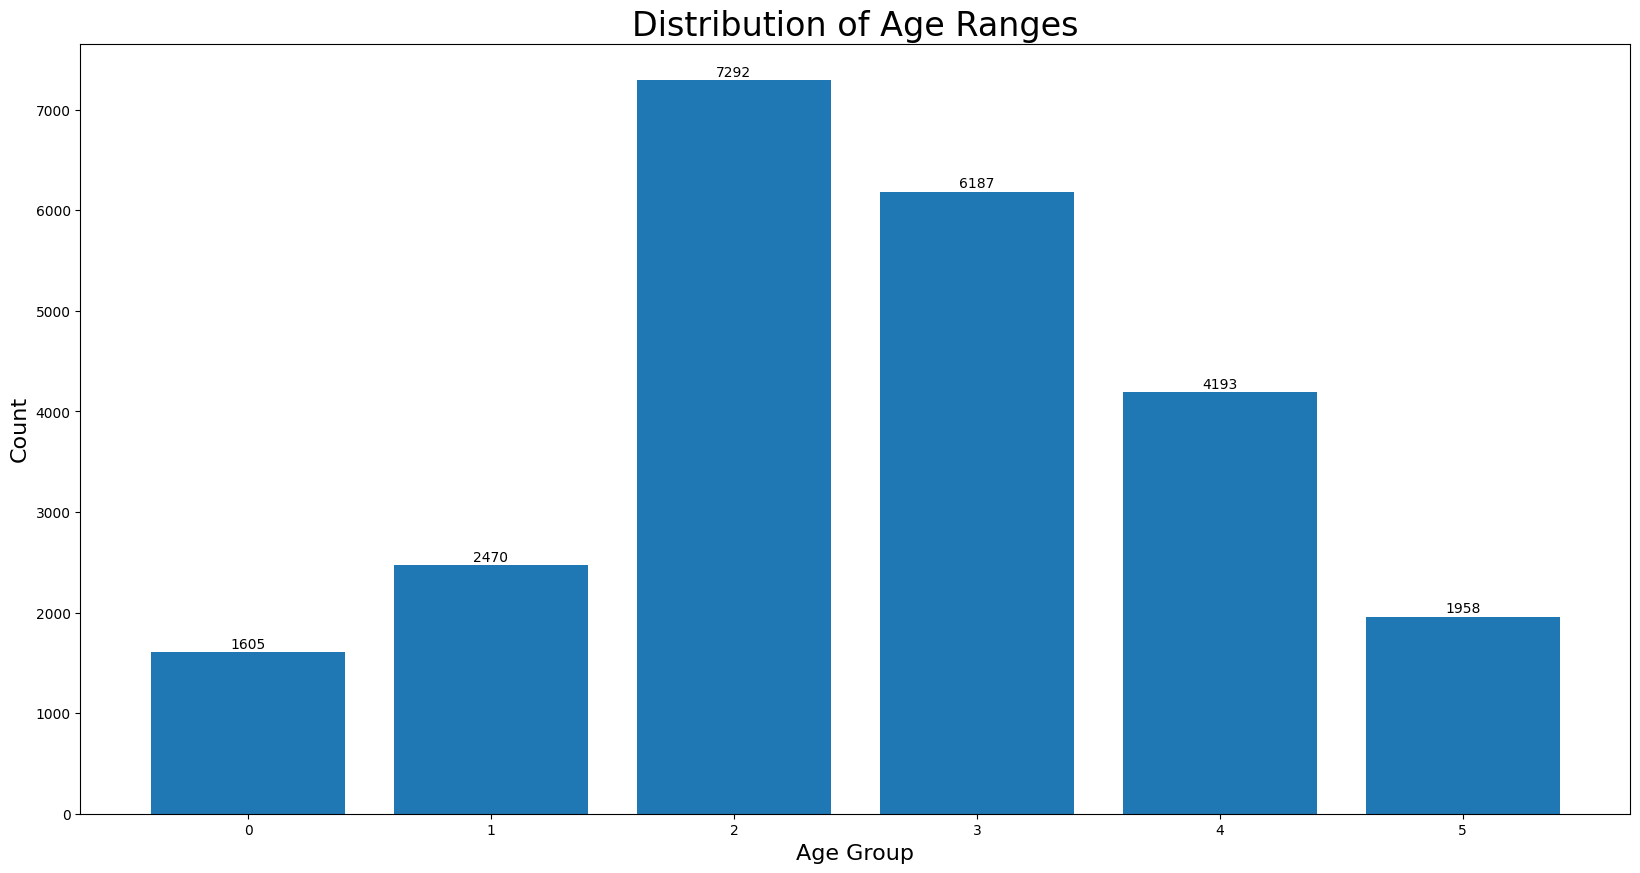

In [92]:
age_group_distribution = df['age_group'].value_counts().sort_index()

plt.figure(figsize=(20, 10))
plt.bar(age_group_distribution.index, age_group_distribution.values)
plt.title("Distribution of Age Ranges", fontsize=24)

for i, count in enumerate(age_group_distribution.values):
    plt.text(age_group_distribution.index[i], count + 10, str(count), ha='center', va='bottom')

plt.xticks(age_group_distribution.index)
plt.xlabel('Age Group', fontsize=16)
plt.ylabel('Count', fontsize=16)

plt.show()

### Reshaping the Pixels Column

In [93]:
df['pixels'] = df['pixels'].apply(lambda x:  np.array(x.split(), dtype='float32'))

df['pixels'][0]

array([129., 128., 128., ..., 146., 146., 146.], dtype=float32)

In [94]:
X = np.array(df['pixels'].tolist())

X.shape

(23705, 2304)

In [95]:
X = X.reshape(-1, 48, 48, 1) # The images are 48x48 mono

X[0].shape

(48, 48, 1)

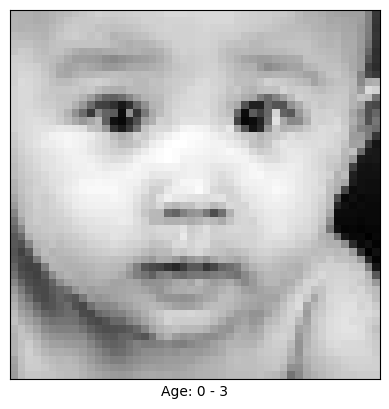

In [96]:
plt.imshow(X[0], cmap='gray')
plt.xlabel(f"Age: {age_group_map[df['age_group'][0]]}")

plt.xticks([])
plt.yticks([])
plt.grid(False)

### Training and Test Split

In [97]:
X = X / 255.0 # Normalizing the inputs
y = tf.keras.utils.to_categorical(np.array(df['age_group']), num_classes=6)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

## The Model

### Initializing the Model

In [184]:
age_detection_model = tf.keras.models.Sequential()

### Building the Model

In [185]:
age_detection_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(48, 48, 1)))
# age_detection_model.add(tf.keras.layers.BatchNormalization())
age_detection_model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
age_detection_model.add(tf.keras.layers.Dropout(0.2))

age_detection_model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
# age_detection_model.add(tf.keras.layers.BatchNormalization())
age_detection_model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
age_detection_model.add(tf.keras.layers.Dropout(0.2))

age_detection_model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu'))
# age_detection_model.add(tf.keras.layers.BatchNormalization())
age_detection_model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
age_detection_model.add(tf.keras.layers.Dropout(0.2))

age_detection_model.add(tf.keras.layers.Flatten())

age_detection_model.add(tf.keras.layers.Dense(units=256, activation='relu'))
age_detection_model.add(tf.keras.layers.Dropout(0.5))

age_detection_model.add(tf.keras.layers.Dense(units=6, activation='softmax'))

### Compiling the Model

In [186]:
age_detection_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Training the Model

In [187]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=20, min_delta=0.001,restore_best_weights=True)

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [188]:
age_detection_model.fit(X_train, y_train, batch_size=32, validation_data=(X_test, y_test), epochs=100, callbacks= [early_stopping, learning_rate_reduction])

Epoch 1/100
593/593 [==============================] - 21s 30ms/step - loss: 1.4484 - accuracy: 0.3765 - val_loss: 1.2109 - val_accuracy: 0.4649 - lr: 0.0010
Epoch 2/100
593/593 [==============================] - 21s 36ms/step - loss: 1.1717 - accuracy: 0.4889 - val_loss: 1.0903 - val_accuracy: 0.5353 - lr: 0.0010
Epoch 3/100
593/593 [==============================] - 22s 36ms/step - loss: 1.0909 - accuracy: 0.5279 - val_loss: 1.0001 - val_accuracy: 0.5680 - lr: 0.0010
Epoch 4/100
593/593 [==============================] - 21s 35ms/step - loss: 1.0334 - accuracy: 0.5491 - val_loss: 0.9536 - val_accuracy: 0.5872 - lr: 0.0010
Epoch 5/100
593/593 [==============================] - 20s 34ms/step - loss: 0.9862 - accuracy: 0.5667 - val_loss: 0.9647 - val_accuracy: 0.5701 - lr: 0.0010
Epoch 6/100
593/593 [==============================] - 21s 36ms/step - loss: 0.9622 - accuracy: 0.5775 - val_loss: 0.8991 - val_accuracy: 0.6096 - lr: 0.0010
Epoch 7/100
593/593 [==============================]